<div align="center">

# **Table of Contents**

</div>

* [**Import Necessary Libraries**](#**import-necessary-libraries**)
* [**Data Loading**](#**data-loading**)
* [**Text Preprocessing**](#**text-preprocessing**)
* [**Feature Extraction with SentenceTransformers**](#**feature-extraction-with-sentencetransformers**)
* [**Dimensionality Reduction for Visualization**](#**dimensionality-reduction-for-visualization**)
* [**K-Means Clustering**](#**k-means-clustering**)

   * [Elbow Method](#elbow-method)
   * [Apply K-Means Clustering](#apply-k-means-clustering)
   * [Plot 2D K-Means clusters using PCA](#plot-2d-k-means-clusters-using-pca)
* [**DBSCAN Clustering**](#**dbscan-clustering**)

   * [K-Distance Graph for Estimating eps in DBSCAN](#k-distance-graph-for-estimating-eps-in-dbscan)
   * [Apply DBSCAN Clustering](#apply-dbscan-clustering)
   * [Plot 2D DBSCAN clusters using PCA](#plot-2d-dbscan-clusters-using-pca)
* [**Hierarchical Clustering**](#**hierarchical-clustering**)

   * [Apply Hierarchical Clustering](#apply-hierarchical-clustering)
   * [Plot 2D hierarchical clusters using PCA](#plot-2d-hierarchical-clusters-using-pca)
* [**Evaluation and Analysis**](#**evaluation-and-analysis**)

   * [Evaluation Metrics](#evaluation-metrics)
   * [Sample Analysis](#sample-analysis)
* [**Theoretical Discussion**](#**theoretical-discussion**)

## **Import Necessary Libraries**

In [ ]:
import nltk
import re
import string
import pandas as pd
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sentence_transformers import SentenceTransformer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score

## **Data Loading**

In [250]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('omw-1.4')

df = pd.read_csv('musicLyrics.csv')
lyrics_data = df['Lyric'].tolist()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\parsa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\parsa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\parsa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\parsa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\parsa\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\parsa\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-d

## **Text Preprocessing**

This section implements the preprocessing of song lyrics from a CSV file. The code reads the lyrics, converts them to lowercase, removes special characters, numbers, punctuation, and stop words, and applies lemmatization to prepare the data for future feature extraction and clustering.

In [251]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def preprocess_text(text):
    if not isinstance(text, str):
        text = ''
    
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)  # Remove [Verse], etc.
    text = re.sub(r'\d+', '', text)      # Remove digits
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\\[a-zA-Z]+', '', text)  # Remove \n, \t, etc.
    
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    pos_tags = pos_tag(tokens)

    lemmatized = [
        lemmatizer.lemmatize(word, get_wordnet_pos(pos))
        for word, pos in pos_tags
    ]

    return ' '.join(lemmatized)

preprocessed_lyrics = [preprocess_text(lyric) for lyric in lyrics_data]

**1. Why is preprocessing performed on the text dataset?**  
Preprocessing cleans and standardizes the text by removing noise (e.g., punctuation, stop words) and normalizing words (e.g., lowercasing, lemmatization). This ensures the data is consistent, reduces irrelevant information, and improves the quality of subsequent analysis like clustering.

**2. Explain the replacement of words using stemming or lemmatization.**  
Stemming reduces words to their root form by removing suffixes (e.g., "running" to "runn"), often producing non-words. Lemmatization maps words to their dictionary form (e.g., "running" to "run") using linguistic rules and POS tagging, preserving meaning for better clustering accuracy.

**3. Why extract features, and why not just rely on reading the text data?**  
Feature extraction converts text into numerical representations (e.g., TF-IDF vectors) that algorithms can process. Raw text is unstructured and cannot be directly used for clustering. Extracted features capture semantic patterns, enabling meaningful grouping of lyrics.

## **Feature Extraction with SentenceTransformers**

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(preprocessed_lyrics, show_progress_bar=True)

embeddings_df = pd.DataFrame(embeddings)
embeddings_df.to_csv('lyrics_embeddings.csv', index=False)

print(f"Feature matrix shape: {embeddings.shape}")

## **Dimensionality Reduction for Visualization**

Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms high-dimensional data into a lower-dimensional space (e.g., 2D) by finding principal components—orthogonal axes that capture the maximum variance in the data. It projects the data onto these components, preserving key patterns while enabling visualization and reducing computational complexity.

C:\Users\parsa\AppData\Local\Temp\ipykernel_2460\2277397556.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], palette='deep')


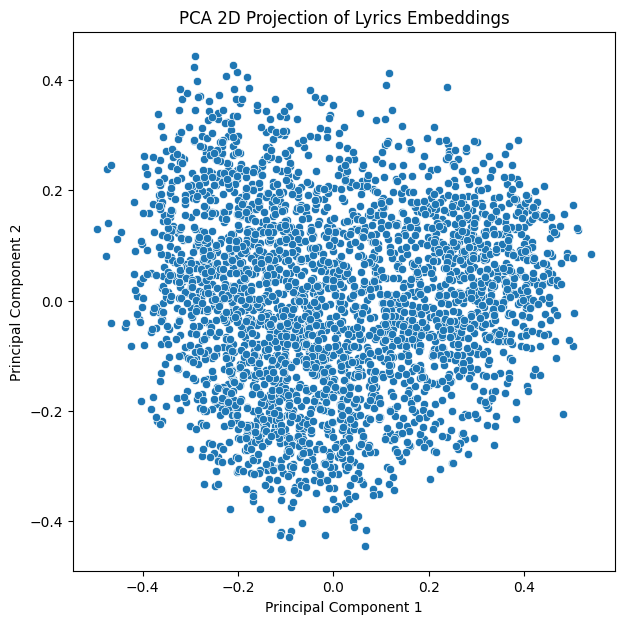

In [238]:
embeddings_df = pd.read_csv('lyrics_embeddings.csv')
embeddings = embeddings_df.to_numpy()

pca = PCA(n_components=2, random_state=42)
reduced_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(7, 7))
sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], palette='deep')
plt.title('PCA 2D Projection of Lyrics Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## **K-Means Clustering**

### Elbow Method

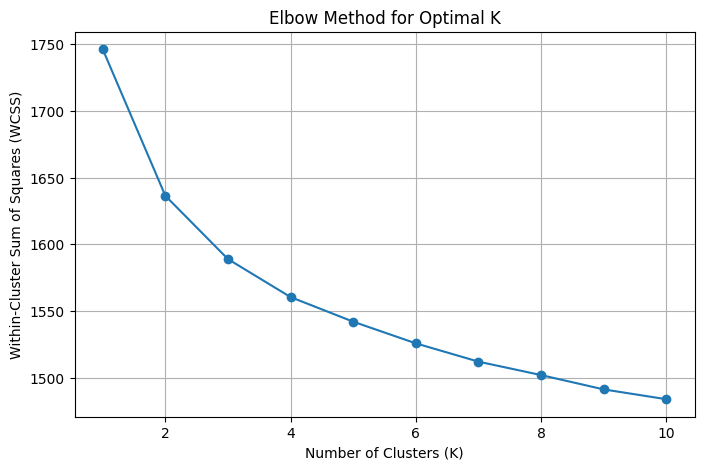

In [239]:
wcss = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, wcss, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

The resulting Elbow plot shows a noticeable bend at ``K = 3``, where the WCSS begins to decrease more slowly, indicating that K = 3 is an appropriate number of clusters for capturing meaningful patterns in the data without overfitting.

### Apply K-Means Clustering

In [240]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(embeddings)

labels_df = pd.DataFrame({'kmeans_cluster': kmeans_labels})
labels_df.to_csv('kmeans_cluster_labels.csv', index=False)

print("Sample cluster labels:")
print(labels_df.head())

Sample cluster labels:
   kmeans_cluster
0               1
1               2
2               1
3               0
4               1


### Plot 2D K-Means clusters using PCA

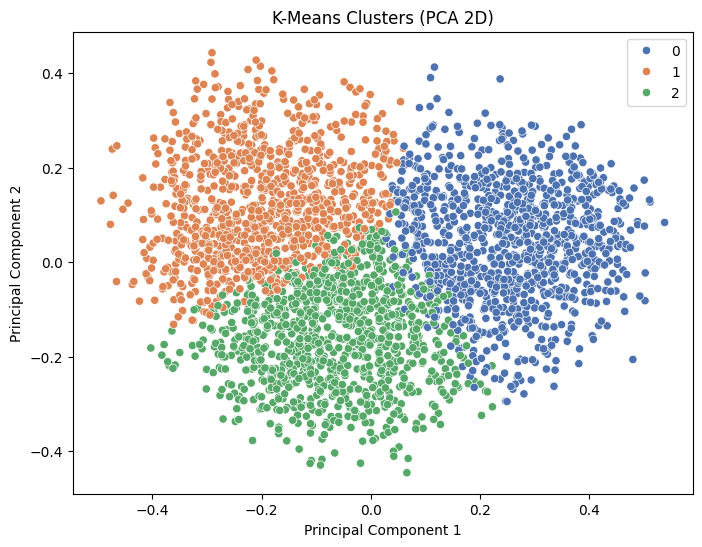

In [241]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=kmeans_labels, palette='deep')
plt.title('K-Means Clusters (PCA 2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## **DBSCAN Clustering**

### K-Distance Graph for Estimating eps in DBSCAN

To determine an appropriate value for the ``eps`` parameter in DBSCAN, we plotted the k-distance graph based on cosine distances between text embeddings.

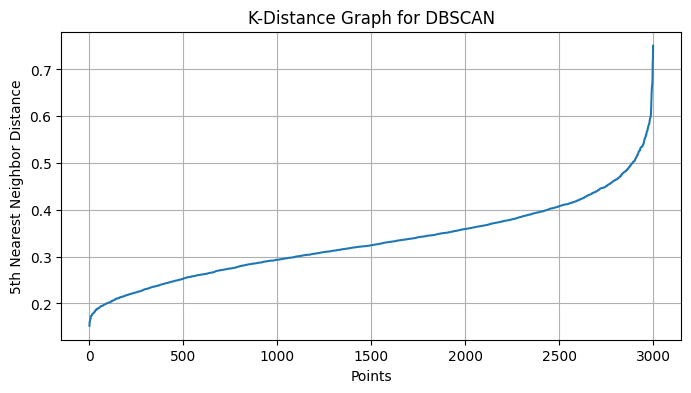

In [242]:
neighbors = NearestNeighbors(n_neighbors=5, metric='cosine')
neighbors_fit = neighbors.fit(embeddings)
distances, indices = neighbors_fit.kneighbors(embeddings)

distances = np.sort(distances[:, 4])
plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("5th Nearest Neighbor Distance")
plt.title("K-Distance Graph for DBSCAN")
plt.grid(True)
plt.show()


### Apply DBSCAN Clustering

In [243]:
dbscan = DBSCAN(eps=0.843, min_samples=3) 
dbscan_labels = dbscan.fit_predict(embeddings)

labels_df = pd.DataFrame({'dbscan_cluster': dbscan_labels})
labels_df.to_csv('dbscan_cluster_labels.csv', index=False)

print("Sample cluster labels:")
print(labels_df.head())

n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)
print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")

Sample cluster labels:
   dbscan_cluster
0               0
1              -1
2               0
3              -1
4               0
Number of clusters: 2
Number of noise points: 706


### Plot 2D DBSCAN clusters using PCA

C:\Users\parsa\AppData\Local\Temp\ipykernel_2460\1539088806.py:10: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(


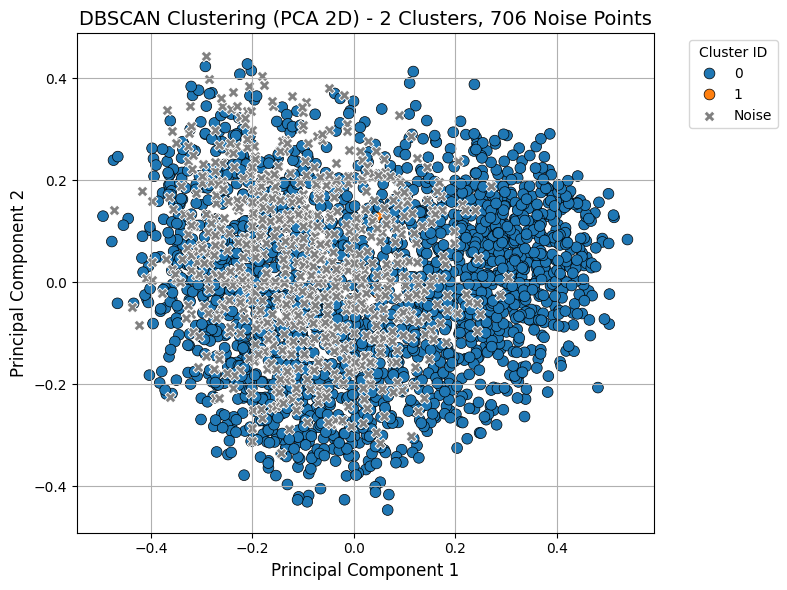

In [244]:
df_vis = pd.DataFrame({
    'PC1': reduced_embeddings[:, 0],
    'PC2': reduced_embeddings[:, 1],
    'Cluster': dbscan_labels
})

plt.figure(figsize=(8, 6))
palette = sns.color_palette('tab10', n_colors=n_clusters + 1)

sns.scatterplot(
    data=df_vis[df_vis['Cluster'] != -1],
    x='PC1', y='PC2',
    hue='Cluster',
    palette=palette,
    legend='full',
    s=60,
    edgecolor='black',
    linewidth=0.5
)

sns.scatterplot(
    data=df_vis[df_vis['Cluster'] == -1],
    x='PC1', y='PC2',
    color='gray',
    label='Noise',
    marker='X',
    s=60
)

plt.title(f'DBSCAN Clustering (PCA 2D) - {n_clusters} Clusters, {n_noise} Noise Points', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()


## **Hierarchical Clustering**

### Apply Hierarchical Clustering

The code applies Hierarchical Clustering using AgglomerativeClustering with ``Euclidean distance`` and ``three clusters``, testing `ward`, `complete`, `average`, and `single` linkage methods on the lyrics dataset's feature vectors.

In [245]:
linkage_methods = ["ward", "complete", "average", "single"]
hierarchical_labels = {}

for linkage in linkage_methods:
    hierarchical = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage=linkage)
    labels = hierarchical.fit_predict(embeddings)
    hierarchical_labels[linkage] = labels

    labels_df = pd.DataFrame({f'hierarchical_{linkage}_cluster': labels})
    labels_df.to_csv(f'hierarchical_{linkage}_cluster_labels.csv', index=False)

### Plot 2D Hierarchical clusters using PCA

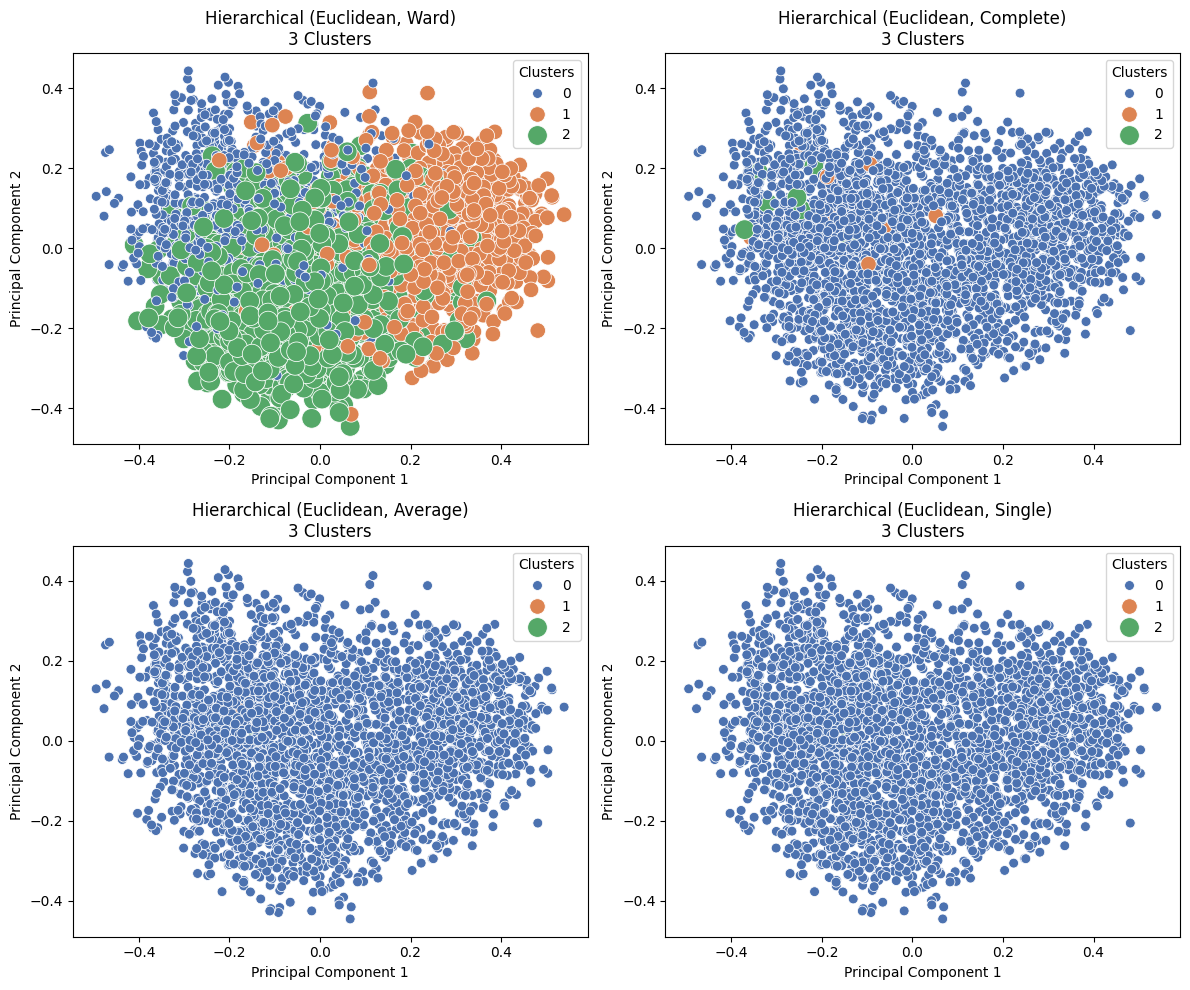

In [246]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, linkage in enumerate(linkage_methods):
    sns.scatterplot(
        x=reduced_embeddings[:, 0], 
        y=reduced_embeddings[:, 1], 
        hue=hierarchical_labels[linkage], 
        palette='deep', 
        size=hierarchical_labels[linkage], 
        sizes=(50, 200), 
        ax=axes[idx]
    )
    axes[idx].set_title(f'Hierarchical (Euclidean, {linkage.capitalize()})\n{len(set(hierarchical_labels[linkage]))} Clusters')
    axes[idx].set_xlabel('Principal Component 1')
    axes[idx].set_ylabel('Principal Component 2')
    axes[idx].legend(title='Clusters')

plt.tight_layout()
plt.show()

## **Evaluation and Analysis**

### Evaluation Metrics

- **Silhouette Score**: Measures cluster cohesion and separation, ranging from -1 to 1 (higher is better). It calculates the average distance of a point to its cluster (a) versus the nearest other cluster (b):  
  $$ 
  s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
  $$
- **Unsuitable Metrics**: Homogeneity, Adjusted Rand Index, and V-Measure require ground truth labels, which are unavailable in this unsupervised lyrics dataset. Metrics like Accuracy or F1-score are also inapplicable due to the lack of labels.

The code computes Silhouette scores for K-Means, DBSCAN, and Hierarchical Clustering (Euclidean, 3 clusters, ward, complete, average, single) using feature vectors. Results are displayed to compare clustering quality.

In [247]:
'''Load feature vectors and cluster labels'''
# embeddings_df = pd.read_csv('lyrics_embeddings.csv')
# embeddings = embeddings_df.to_numpy()

# kmeans_labels = pd.read_csv('kmeans_cluster_labels.csv')['kmeans_cluster']
# dbscan_labels = pd.read_csv('dbscan_cluster_labels.csv')['dbscan_cluster']
# hierarchical_labels = {
#     linkage: pd.read_csv(f'hierarchical_{linkage}_cluster_labels.csv')[f'hierarchical_{linkage}_cluster']
#     for linkage in ["ward", "complete", "average", "single"]
# }

silhouette_scores = {
    'K-Means': silhouette_score(embeddings, kmeans_labels),
    'DBSCAN': silhouette_score(embeddings, dbscan_labels) if len(set(dbscan_labels)) > 1 else 'N/A',
}

for linkage in hierarchical_labels:
    silhouette_scores[f'Hierarchical ({linkage.capitalize()})'] = silhouette_score(embeddings, hierarchical_labels[linkage])

print("Silhouette Scores (higher is better, range: -1 to 1):")
for method, score in silhouette_scores.items():
    print(f"{method}: {score if score != 'N/A' else 'N/A (single cluster or noise-only)'}")

Silhouette Scores (higher is better, range: -1 to 1):
K-Means: 0.05123998758000666
DBSCAN: 0.027537782271947305
Hierarchical (Ward): 0.032592908751425315
Hierarchical (Complete): 0.15170346648349056
Hierarchical (Average): 0.20255219169908792
Hierarchical (Single): 0.19954646155823455


### Sample Analysis

This section completes the evaluation by printing two sample lyrics from each cluster for K-Means, DBSCAN, and Hierarchical Clustering (Euclidean, ward, complete, average, single) and comparing their semantic and thematic similarity.

In [ ]:
def print_cluster_samples(labels, method_name, n_samples=2):
    unique_clusters = sorted(set(labels) - {-1}) 
    print(f"\n{method_name} Samples:")
    for cluster in unique_clusters:
        cluster_indices = np.where(labels == cluster)[0]
        if len(cluster_indices) >= n_samples:
            sample_indices = np.random.choice(cluster_indices, n_samples, replace=False)
            print(f"\nCluster {cluster}:")
            for idx in sample_indices:
                print(f" - Lyric: {lyrics_data[idx][:]}")
        else:
            print(f"\nCluster {cluster}: Insufficient samples")

print_cluster_samples(kmeans_labels, "K-Means")
print_cluster_samples(dbscan_labels, "DBSCAN")
for linkage in hierarchical_labels:
    print_cluster_samples(hierarchical_labels[linkage], f"Hierarchical ({linkage.capitalize()})")


K-Means Samples:

Cluster 0:
 - Lyric: Modern girls!! sung I know, I cant afford to stop For a moment.. that its too soon.. to for.. [Mos Def] speaking over sung vocals I say girls, girls, girls, girls Reach out and clap your hands I be the fabulous man so, just play the fabulous fan And, bring the breeze, bring the breeze [Mos Def] And from the moment that I saw ya, I knew you was trouble But I disregarded, detour signs And did not stop til you was mine I guess God was like, aight fine Careful what you wish for, cause you just might get it in heaps Try to give it back he be like nah thats yours to keep So poetic baby girl you make it hard to speak My dream lover make it hard to sleep .. I wrote a little song about it In she came with the same type game The hairdo, Prada shoes, brand new Gucci frame Big thangs, so big you cant hardly explain When she done crossed her legs, she make mind turn insane Had seen her on the ave and spotted her, how I wanted her Ass so fat she think police t

**Sample Analysis**  
- **K-Means**: Cluster 0 samples focus on urban life and relationships, with themes of confidence and street culture. Cluster 1 samples are religious and narrative-driven, centered on sacrifice and resurrection. Cluster 2 samples emphasize romantic love and emotional vulnerability, showing thematic consistency within clusters.
- **DBSCAN**: Cluster 0 samples address perseverance and social issues, sharing motivational themes. Cluster 1 samples depict dramatic, action-oriented narratives, less thematically cohesive. Noise points indicate outliers with diverse themes.
- **Hierarchical (Ward)**: Cluster 0 samples explore adventure and existential themes, Cluster 1 combines mythological and introspective lyrics, and Cluster 2 focuses on light-hearted or intense personal narratives, showing moderate coherence.
- **Hierarchical (Complete)**: Cluster 0 samples blend mythological and spiritual themes, Cluster 1 includes procedural and abrupt texts, and Cluster 2 (scientific text) is an outlier, indicating varied coherence.
- **Hierarchical (Average)**: Cluster 0 samples focus on emotional struggles, Cluster 1 on procedural or minimalistic texts, with Cluster 2 having insufficient samples, suggesting uneven cluster sizes.
- **Hierarchical (Single)**: Cluster 0 samples highlight dark, rebellious themes, while Clusters 1 and 2 lack sufficient samples, indicating poor cluster distribution due to chaining effects.


## **Theoretical Discussion**

* **Supervised vs. Unsupervised Learning**  
Supervised learning uses labeled data to train models for prediction (e.g., classification, regression), relying on input-output pairs. Unsupervised learning, used here, works with unlabeled data to find patterns, such as clustering or dimensionality reduction. Supervised methods require labeled data and predict specific outcomes, while unsupervised methods explore data structure, making them suitable for tasks like lyrics clustering without predefined categories.

* **Purpose and Characteristics of Feature Vectors**  
Feature vectors convert text into numerical representations (e.g., embeddings from SentenceTransformers) for machine learning. They capture semantic and contextual information, enabling algorithms to process text. Characteristics include high dimensionality, sparsity (in some methods), and context sensitivity, crucial for clustering lyrics by themes or styles.

* **Clustering Methods Used**  
    - **K-Means**: Partitions data into K clusters by minimizing within-cluster variance. It assumes spherical clusters and requires K to be predefined.
    - **DBSCAN**: Groups points based on density, identifying clusters of arbitrary shape and noise points. It uses `eps` (distance threshold) and `min_samples`.
    - **Hierarchical Clustering**: Builds a hierarchy of clusters using linkage methods (`ward`, `complete`, `average`, `single`), merging points based on distance (`Euclidean` here).

* **Text Vectorization Methods**  
    - **Methods**: Include Bag of Words, TF-IDF, and embeddings (e.g., SentenceTransformers). SentenceTransformers, used here, generates dense vectors capturing semantic meaning via transformer models.
    - **How They Work**: Traditional methods like Bag of Words and TF-IDF convert text into sparse vectors based on word frequency and importance. In contrast, embedding-based methods (e.g., Word2Vec, GloVe, SentenceTransformers) use pre-trained models to generate dense vectors that capture semantic and contextual information.
    - **Advantages**: Capture semantic relationships, robust to word variations.
    - **Disadvantages**: Computationally intensive, high-dimensional output requiring reduction (e.g., PCA).

* **SentenceTransformers and all-MiniLM-L6-v2**  
SentenceTransformers is a framework for generating text embeddings using transformer models. The `all-MiniLM-L6-v2` model is a compact transformer with 6 layers, optimized for sentence-level tasks, producing 384-dimensional embeddings. It balances efficiency and performance for clustering tasks like lyrics analysis.

* **Elbow Method in K-Means**  
The Elbow Method determines the optimal K by plotting Within-Cluster Sum of Squares (WCSS) against K values (1 to 10 here). The "elbow" point, where WCSS decreases slowly, indicates the best K, balancing cluster cohesion and simplicity.

* **Comparison of Clustering Outputs** 
    - **K-Means**: Produces compact, evenly sized clusters but assumes spherical shapes, potentially missing complex patterns. Effective for well-separated lyrics themes.
    - **DBSCAN**: Identifies dense clusters and noise, suitable for irregular shapes but sensitive to parameter tuning, potentially labeling many points as noise.
    - **Hierarchical**: Offers flexible linkage methods; `ward` forms tight clusters, while `single` may create elongated ones. 

> ### **In Conclusion**
`Hierarchical Clustering` with `average` linkage is the superior method based on the highest Silhouette score (0.203), reflecting well-separated and cohesive clusters. Sample analysis supports this, as clusters show thematic consistency. K-Means produces consistent but less distinct clusters, while DBSCAN struggles with noise and parameter sensitivity. Hierarchical *Single* forms unbalanced clusters, and *Ward* and *Complete* are outperformed by *Average*. The *average* linkage balances inter-cluster distances, making it effective for the diverse thematic structure of the lyrics dataset. Visual inspection of PCA plots can further confirm the quality of clusters.